# 0. Import and Install Dependencies

In [ ]:
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python mediapipe sklearn matplotlib

In [26]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import mediapipe as mp

# 1. Keypoints using MP Holistic

In [27]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [28]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [29]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACE_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             )

In [32]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

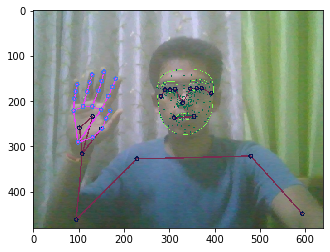

In [33]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [35]:
len(results.face_landmarks.landmark)

468

# 2. Extract Keypoint Values

In [36]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate ([pose, face, lh, rh])

In [37]:
result_test = extract_keypoints(results)

In [38]:
np.save('0', result_test)

In [39]:
np.load('0.npy')

array([ 0.51592678,  0.42663485, -1.14091277, ...,  0.15237384,
        0.34111199, -0.10530367])

# 3. Setup Folders for Collection

In [40]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
actions = np.array(['hello', 'thanks', 'iloveyou'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

# Folder start
start_folder = 30

In [41]:
for action in actions: 
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

# 4. Collect Keypoint Values for Training and Testing

In [ ]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(start_folder, start_folder+no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(500)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

# 5. Preprocess Data and Create Labels and Features

In [42]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [43]:
label_map = {label:num for num, label in enumerate(actions)}

In [44]:
label_map

{'hello': 0, 'iloveyou': 2, 'thanks': 1}

In [ ]:
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [ ]:
X = np.array(sequences)

In [ ]:
X.shape

In [ ]:
y = to_categorical(labels).astype(int)

In [ ]:
y.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

# 6. Build and Train LSTM Neural Network

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [47]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [48]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [49]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback])

In [50]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 30, 64)            442112    
_________________________________________________________________
lstm_4 (LSTM)                (None, 30, 128)           98816     
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 99        
Total params: 596,675
Trainable params: 596,675
Non-trainable params: 0
________________________________________________

# 7. Make Predictions

In [ ]:
res = model.predict(X_test)

In [ ]:
actions[np.argmax(res[4])]

In [ ]:
actions[np.argmax(y_test[4])]

# 8. Save Weights

In [ ]:
model.save('action.h5')

In [ ]:
del model

In [51]:
model.load_weights('action.h5')

# 9. Evaluation using Confusion Matrix and Accuracy

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [ ]:
yhat = model.predict(X_test)

In [ ]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [ ]:
multilabel_confusion_matrix(ytrue, yhat)

In [ ]:
accuracy_score(ytrue, yhat)

# 10. Test in Real Time

In [52]:
from scipy import stats

In [53]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

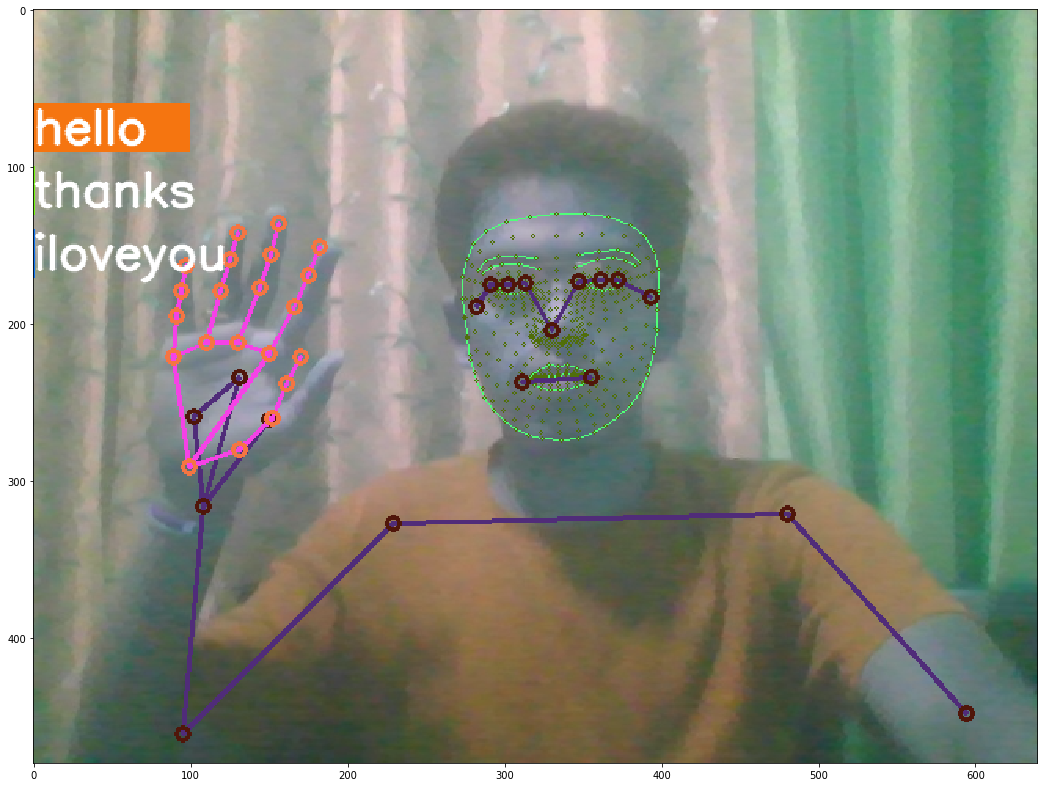

In [54]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))

In [76]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH) + 0.5)
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT) + 0.5)
size = (width, height)
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('your_video.avi', fourcc, 10.0, size)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        out.write(image)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)
        
        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    out.release()
    cv2.destroyAllWindows()

iloveyou
iloveyou
iloveyou
iloveyou
hello
hello
hello
hello
hello
hello
hello
hello
hello
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
